In [1]:
bicycle = "http://josephsalmon.eu/enseignement/datasets/bicycle_db.csv"
path_bicycle = "./data/bicycle.txt"
pollution = "http://josephsalmon.eu/enseignement/datasets/Mesure_journaliere_Region_Occitanie_Polluants_Principaux.csv"

In [2]:
from download import download
import patsy
import numpy as np
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import t

sns.set_palette("colorblind")

%matplotlib notebook

In [3]:
download(bicycle, path_bicycle, replace=False)

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


'./data/bicycle.txt'

In [4]:
df_bicycle = pd.read_csv(path_bicycle, sep=",", skiprows=2, converters={"heure": str})
pd.options.display.max_columns = 39
df_bicycle.head()

/home/tanglef/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,type intersection,type collision,luminosite,conditions atmosperiques,type route,circulation,nb voies,profil long route,trace plan route,largeur TPC,largeur route,etat surface,amenagement,situation,categorie usager,gravite accident,sexe,age,motif deplacement,existence securite,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules
0,200500000030,2005-01-13,01 - janvier,3 - jeudi,19,62,62331,50.300,2.840,oui,Hors intersection,Deux véhicules - par le coté,Nuit avec éclairage public allumé,Normale,Route Départementale,NaN,NaN,NaN,Partie rectiligne,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,57-58,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Côté gauche,Changeant de file à gauche,200500000030B02,Transport en commun,Dépassant à gauche,1.0
1,200500000034,2005-01-19,01 - janvier,2 - mercredi,10,62,62022,0.000,0.000,non,Hors intersection,Deux véhicules - frontale,Plein jour,Temps éblouissant,Route Départementale,NaN,NaN,Plat,En courbe à droite,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,2 - Blessé hospitalisé,M,19-20,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Avant,Sans changement de direction,200500000034B02,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...",Tournant à gauche,1.0
2,200500000078,2005-01-26,01 - janvier,2 - mercredi,13,02,02173,0.000,0.000,non,Autre intersection,Deux véhicules - par le coté,Plein jour,Normale,Route Départementale,NaN,2.0,Pente,Partie rectiligne,NaN,NaN,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,70-71,Promenade - loisirs,Casque,Non,NaN,Véhicule,Avant,Sans changement de direction,200500000078B02,VL seul,Tournant à gauche,1.0
3,200500000093,2005-01-03,01 - janvier,0 - lundi,13,02,02810,49.255,3.094,oui,Hors intersection,Deux véhicules - frontale,Plein jour,Normale,Route Départementale,NaN,NaN,Plat,En courbe à gauche,NaN,52.0,normale,NaN,Sur chaussée,Conducteur,2 - Blessé hospitalisé,F,50-51,Utilisation professionnelle,NaN,NaN,NaN,Véhicule,Avant gauche,Manœuvre d’évitement,200500000093B02,VL seul,Manœuvre d’évitement,1.0
4,200500000170,2005-01-29,01 - janvier,5 - samedi,18,76,76196,0.000,0.000,non,Hors intersection,Deux véhicules - par l’arrière,Nuit sans éclairage public,Normale,Route Départementale,NaN,2.0,Plat,Partie rectiligne,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,73-74,Promenade - loisirs,Autre,Oui,NaN,Véhicule,Arrière,"Même sens, même file",200500000170A01,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...","Même sens, même file",1.0


In [5]:
df_bicycle = df_bicycle[["date", "mois", "jour", "heure", "departement", "en agglomeration",
                       "conditions atmosperiques", "categorie usager", "gravite accident",
                       "sexe", "age", "existence securite"]]
df_bicycle["heure"].replace("", np.nan, inplace=True)
df_bicycle["age"].replace(["2004-2005", "2016-2017", "2006-2007", "2012-2013", "2013-2014",
                           '2005-2006', "2006-2007"], np.nan, inplace=True)
df_bicycle["existence securite"].replace("Inconnu", np.nan, inplace=True)
df_bicycle.dropna(inplace=True)
df_bicycle.rename(columns = {"conditions atmosperiques": "conditions atmospheriques", "gravite accident": "gravite_accident"}, inplace=True)

for i, name in enumerate(df_bicycle.columns):
    print("\n############################")
    print("Column", name)
    print(df_bicycle[df_bicycle.columns[i]].unique(), "\n")


############################
Column date
['2005-01-26' '2005-01-29' '2005-01-23' ... '2018-12-02' '2018-11-17'
 '2018-12-01'] 


############################
Column mois
['01 - janvier' '02 - février' '03 - mars' '04 - avril' '05 - mai'
 '06 - juin' '07 - juillet' '08 - aout' '09 - septembre' '10 - octobre'
 '11 - novembre' '12 - décembre'] 


############################
Column jour
['2 - mercredi' '5 - samedi' '6 - dimanche' '3 - jeudi' '0 - lundi'
 '4 - vendredi' '1 - mardi'] 


############################
Column heure
['13' '18' '10' '15' '17' '9' '22' '16' '12' '11' '14' '19' '21' '7' '20'
 '6' '8' '3' '23' '4' '5' '2' '1'] 


############################
Column departement
['02' '76' '35' '29' '56' '14' '50' '49' '72' '33' '47' '32' '69' '07'
 '38' '42' '57' '68' '51' '52' '89' '25' '83' '84' '03' '06' '08' '10'
 '12' '13' '17' '21' '24' '26' '31' '34' '37' '40' '41' '44' '45' '54'
 '55' '59' '61' '62' '63' '64' '65' '67' '71' '74' '75' '77' '78' '80'
 '82' '86' '87' '91' '92' 

In [6]:
df_bicycle.head()

,date,mois,jour,heure,departement,en agglomeration,conditions atmospheriques,categorie usager,gravite_accident,sexe,age,existence securite
2,2005-01-26,01 - janvier,2 - mercredi,13,02,non,Normale,Conducteur,1 - Blessé léger,M,70-71,Casque
4,2005-01-29,01 - janvier,5 - samedi,18,76,non,Normale,Conducteur,1 - Blessé léger,M,73-74,Autre
5,2005-01-23,01 - janvier,6 - dimanche,18,35,oui,Normale,Conducteur,2 - Blessé hospitalisé,M,45-46,Casque
8,2005-01-08,01 - janvier,5 - samedi,10,29,non,Normale,Conducteur,2 - Blessé hospitalisé,M,57-58,Casque
9,2005-01-13,01 - janvier,3 - jeudi,15,29,oui,Temps éblouissant,Conducteur,1 - Blessé léger,M,75-76,Casque


In [7]:
df_bicycle.set_index(pd.to_datetime(df_bicycle["heure"] + "/00 "+
                            df_bicycle["date"],
                            format="%H/%M %Y-%m-%d"), inplace=True)
df_bicycle.drop(columns=["date"], inplace=True)
df_bicycle.head()

,mois,jour,heure,departement,en agglomeration,conditions atmospheriques,categorie usager,gravite_accident,sexe,age,existence securite
2005-01-26 13:00:00,01 - janvier,2 - mercredi,13,02,non,Normale,Conducteur,1 - Blessé léger,M,70-71,Casque
2005-01-29 18:00:00,01 - janvier,5 - samedi,18,76,non,Normale,Conducteur,1 - Blessé léger,M,73-74,Autre
2005-01-23 18:00:00,01 - janvier,6 - dimanche,18,35,oui,Normale,Conducteur,2 - Blessé hospitalisé,M,45-46,Casque
2005-01-08 10:00:00,01 - janvier,5 - samedi,10,29,non,Normale,Conducteur,2 - Blessé hospitalisé,M,57-58,Casque
2005-01-13 15:00:00,01 - janvier,3 - jeudi,15,29,oui,Temps éblouissant,Conducteur,1 - Blessé léger,M,75-76,Casque


In [8]:
df_bicycle["heure"] = pd.to_numeric(df_bicycle["heure"])

<IPython.core.display.Javascript object>


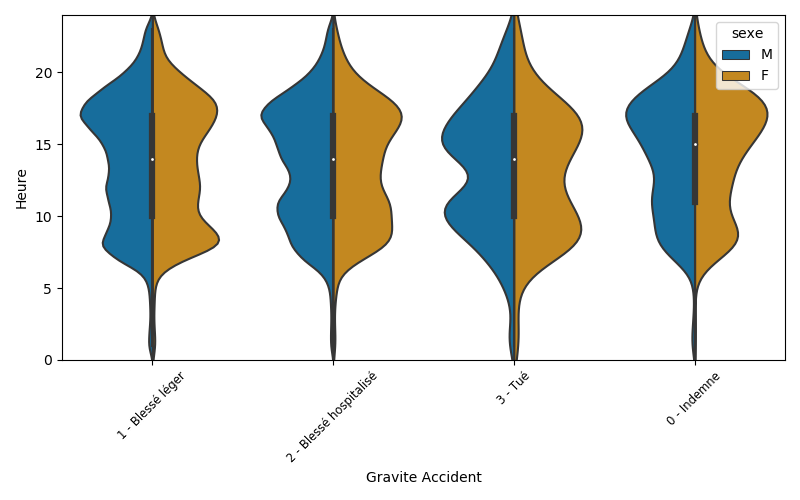

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.violinplot(x="gravite_accident", y="heure", hue = "sexe",
                    split=True, data=df_bicycle)
ax.set_xlabel('Gravite Accident')
ax.set_ylabel('Heure')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='small')
plt.ylim([0,24])
plt.tight_layout()
plt.show()

In [10]:
lm_time_gravity = ols('heure ~ C(gravite_accident)', data=df_bicycle).fit()
print(lm_time_gravity.summary())

                            OLS Regression Results                            
Dep. Variable:                  heure   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     27.50
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           9.22e-18
Time:                        14:19:46   Log-Likelihood:            -1.7411e+05
No. Observations:               60123   AIC:                         3.482e+05
Df Residuals:                   60119   BIC:                         3.483e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [11]:
anova_time_grav = sm.stats.anova_lm(lm_time_gravity, typ=2)
anova_time_grav

,sum_sq,df,F,PR(>F)
C(gravite_accident),1.582434e+03,3.0,27.496566,9.223309e-18
Residual,1.153287e+06,60119.0,NaN,NaN


<IPython.core.display.Javascript object>


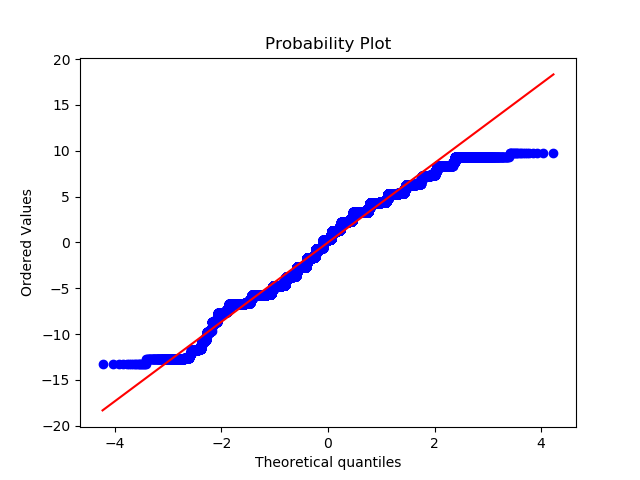

In [22]:
resid = lm_time_gravity.resid
import scipy as sp
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(resid, plot=ax, fit=True)